## Examples used in the slides for the SCALA@SC paper presentation
- Fitting data for execution logs or for synthetic logs
- Generating the sequence of requests
- Computing the cost of a sequence

Input data is represented by:
 * Log data for neuroscience applications (log_example.in)
     * Array of past execution times
 * Synthetic data

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import random

import WorkloadCDF
import OptimalSequence

In [2]:
plot = False

# Log data

If cost is needed use:
`cost_model = WorkloadFit.LogDataCost(data)`

This example computes the sequence of requests
- using the discrete data
- using both interpolation models (polynomial and distribution) to go through a continuous fit
- using distribution interpolation for the checkpoint sequence model

In [3]:
dataset = "./log_example.in"
data = np.loadtxt(dataset, delimiter=' ')
print("Total entries in the historic data: %d" %(len(data)))

Total entries in the historic data: 732


# Compute the discrete CDF

Plot it and show best fit by connecting adiacent points with a line

In [4]:
# Optimal CDF by using the descrete full data

wf = WorkloadCDF.WorkloadCDF(data)
optimal_data, optimal_cdf = wf.compute_discrete_cdf()

handler = OptimalSequence.TODiscretSequence(max(data), optimal_data, optimal_cdf)
optimal_sequence = handler.compute_request_sequence()
print("Optimal sequence", optimal_sequence)

Optimal sequence [(99019.0,), (201581.0,), (431158.0,), (965164.0,)]


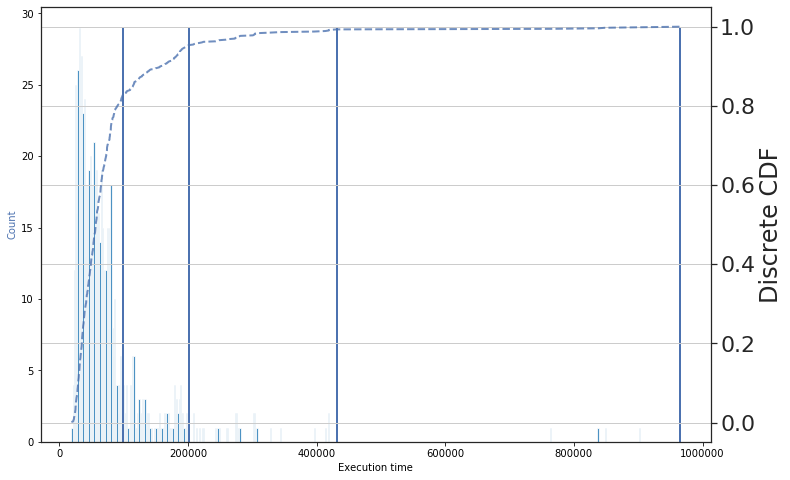

In [5]:
# plot the data and the descrete CDF (consecutive points joined by a line)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)

# plot sequence
ax.vlines(optimal_sequence[0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot discrete fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8)
#ax2.scatter(optimal_data, optimal_cdf, marker="s", color="r", lw=2, alpha=1)

plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="b")
if plot:
    plt.savefig("figures/optimal_sequence.png")
plt.show()

# Interpolate the CDF with a distribution fit

- get best disribution base on the fit

In [6]:
# compute the interpolation of the CDF points
wf.set_interpolation_model([WorkloadCDF.DistInterpolation(data)])
best_fit = wf.compute_best_cdf_fit()
if best_fit != -1:
     best_fit = wf.get_best_fit()
print(best_fit)

(<scipy.stats._continuous_distns.dweibull_gen object at 0x7ff80404aa90>, (0.7769322319646739, 52788.999999999985, 34791.237937332946), 243.3195805500859)


In [7]:
all_data_discrete, all_data_cdf = wf.get_interpolation_cdf(data, best_fit)

handler = OptimalSequence.TODiscretSequence(max(data), all_data_discrete, all_data_cdf)
distr_sequence = handler.compute_request_sequence()
print("Distribution sequence", distr_sequence)

Distribution sequence [(86031.0,), (201581.0,), (431158.0,), (965164.0,)]


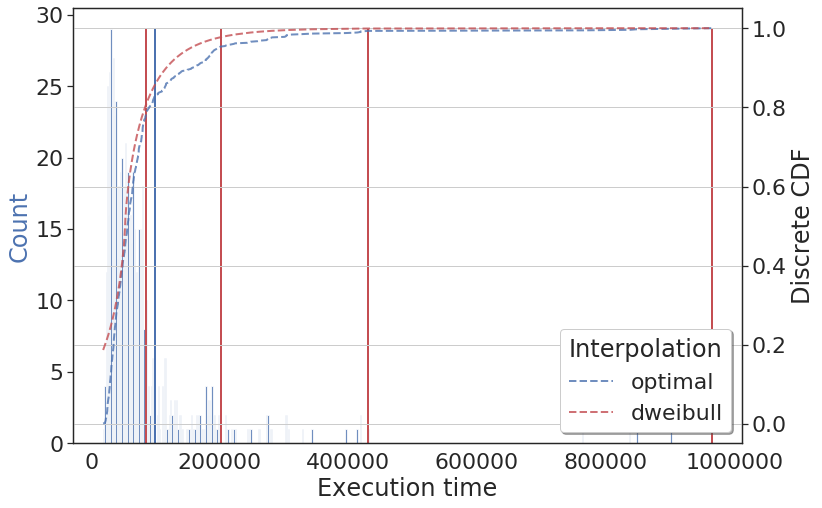

In [8]:
# plot the data and the descrete CDF (consecutive points joined by a line)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)

# plot optimal sequence
ax.vlines(optimal_sequence[0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot polynomial fit sequence
ax.vlines(distr_sequence[0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(distr_sequence)):
    ax.vlines(distr_sequence[i], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# polynomial fit
ax2.plot(all_data_discrete, all_data_cdf, 'r--', lw=2, alpha=0.8, label=best_fit[0].name)

ax2.legend(shadow=True, title="Interpolation")
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="b")
if plot:
    plt.savefig("figures/distr_sequence.png")
plt.show()

# Use only the first x entris in data for interpolation

In [9]:
# define x
training_size = 10

In [10]:
training_data = random.sample(list(data), training_size)
wf = WorkloadCDF.WorkloadCDF(training_data)
discret_data, cdf = wf.compute_discrete_cdf()

handler = OptimalSequence.TODiscretSequence(max(data), discret_data, cdf)
discrete_sequence = handler.compute_request_sequence()
print("Optimal sequence", discrete_sequence)

Optimal sequence [(130432.0,), (848470.0,), (965164.0,)]


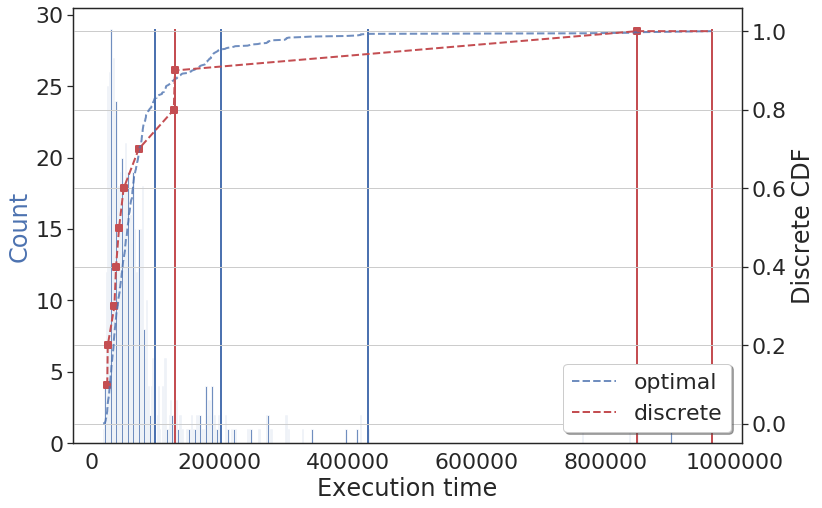

In [11]:
# plot the data and the descrete CDF (consecutive points joined by a line)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)

# plot optimal sequence
ax.vlines(optimal_sequence[0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i], min(counts), max(counts), colors='b', lw=2, linestyles='solid')


# plot the discrete sequence
ax.vlines(discrete_sequence[0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='discrete')
for i in range(1,len(discrete_sequence)):
    ax.vlines(discrete_sequence[i], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# plot sample data
ax2.plot(discret_data + [max(data)], cdf + [1], 'r--', lw=2, alpha=1, label="discrete")
ax2.scatter(discret_data, cdf, marker="s", color="r", lw=2, alpha=1)

ax2.legend(shadow=True)
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="b")
if plot:
    plt.savefig("figures/training%d_discrete_seq.png" %(training_size))
plt.show()

# Plot best polynomial and distribution fits compared to the optimal

In [12]:
wf.set_interpolation_model([WorkloadCDF.PolyInterpolation(max_order=10)])
best_fit_poly = wf.compute_best_cdf_fit()
if best_fit_poly != -1:
     best_fit_poly = wf.get_best_fit()
print(best_fit_poly)
all_data_discrete, all_data_cdf = wf.get_interpolation_cdf(data, best_fit_poly[1])

handler = OptimalSequence.TODiscretSequence(max(data), all_data_discrete, all_data_cdf)
poly_sequence = handler.compute_request_sequence()
print("Polynomial sequence", poly_sequence)

(9, array([ 9.69440440e-42, -1.32934398e-35,  5.39866134e-30, -1.06114286e-24,
        1.18476078e-19, -8.02484015e-15,  3.35575077e-10, -8.45251064e-06,
        1.17363468e-01, -6.88743669e+02]), 3.527041071025737e-05)
Polynomial sequence [(86031.0,), (201581.0,), (431158.0,), (965164.0,)]


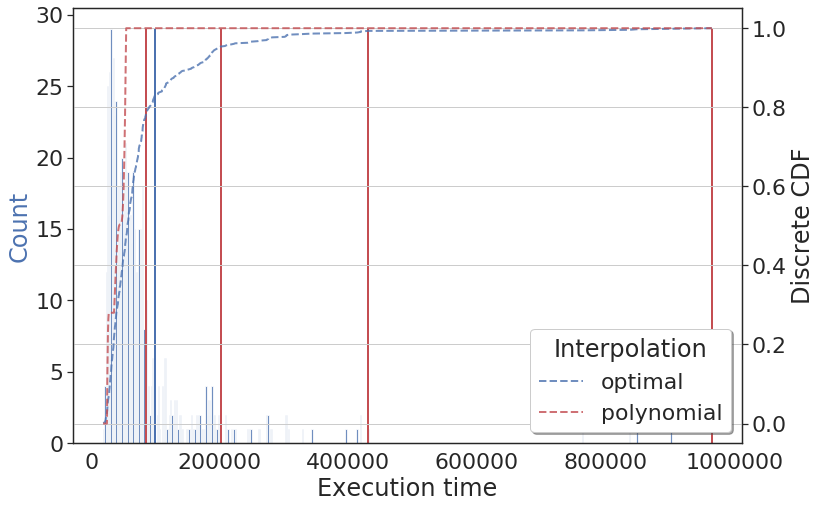

In [13]:
# plot the data and the descrete CDF (consecutive points joined by a line)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)

# plot optimal sequence
ax.vlines(optimal_sequence[0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot polynomial fit sequence
ax.vlines(poly_sequence[0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(poly_sequence)):
    ax.vlines(poly_sequence[i], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# polynomial fit
ax2.plot(all_data_discrete, all_data_cdf, 'r--', lw=2, alpha=0.8, label="polynomial")

ax2.legend(shadow=True, title="Interpolation")
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="b")
if plot:
    plt.savefig("figures/training%d_poly_seq.png" %(training_size))
plt.show()

# Distribution interpolation

In [14]:
# compute the interpolation of the CDF points
wf.set_interpolation_model([WorkloadCDF.DistInterpolation(data)])
best_fit = wf.compute_best_cdf_fit()
if best_fit != -1:
     best_fit = wf.get_best_fit()
print(best_fit)
all_data_discrete, all_data_cdf = wf.get_interpolation_cdf(data, best_fit)

handler = OptimalSequence.TODiscretSequence(max(data), all_data_discrete, all_data_cdf)
distr_sequence = handler.compute_request_sequence()
print("Distribution sequence", distr_sequence)

(<scipy.stats._continuous_distns.alpha_gen object at 0x7ff80415f7f0>, (2.030285888788022, -8365.726343673465, 128713.60045843257), 3.84991808619474)
Distribution sequence [(86031.0,), (201581.0,), (431158.0,), (965164.0,)]


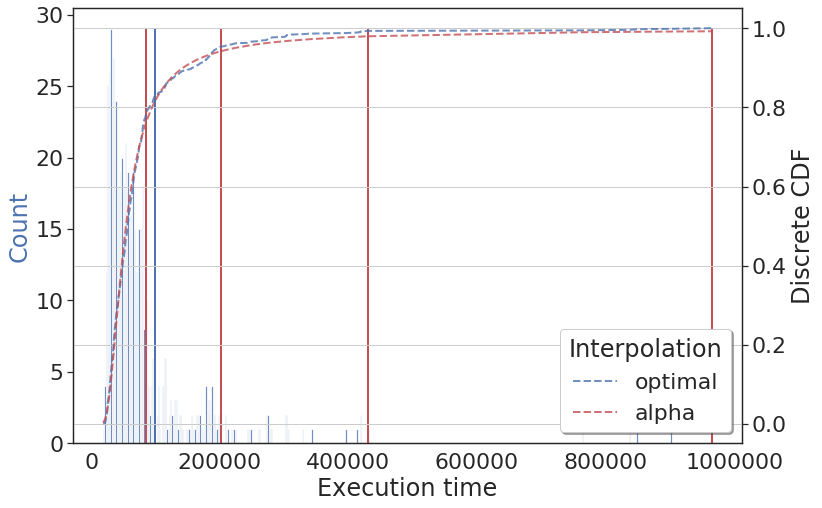

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)

# plot optimal sequence
ax.vlines(optimal_sequence[0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot polynomial fit sequence
ax.vlines(distr_sequence[0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(distr_sequence)):
    ax.vlines(distr_sequence[i], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# polynomial fit
ax2.plot(all_data_discrete, all_data_cdf, 'r--', lw=2, alpha=0.8, label=best_fit[0].name)

ax2.legend(shadow=True, title="Interpolation")
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="b")
if plot:
    plt.savefig("figures/training%d_distr_seq.png" %(training_size))
plt.show()